# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we deploy the BatchNorm instead of Tanh activation right before the encoder's output.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC_BatchNorm"
text_head_model = "FC_BatchNorm"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:20<00:00,  4.74it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:47<00:00, 20.74it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:06<00:00,  7.04it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:20<00:00, 20.98it/s]


=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


In [ ]:
epochs = 20
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 525,056


## 2. Training

In [ ]:
print("Start Training...")
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
_, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)
pos_loss, neg_loss = utils.eval_decomposed(testloader, image_head, text_head)

Start Training...
Epoch: 2 | Training loss: 0.1610 | Test loss: 0.1555
Epoch: 4 | Training loss: 0.0974 | Test loss: 0.1361
Epoch: 6 | Training loss: 0.0836 | Test loss: 0.1330
Epoch: 8 | Training loss: 0.0773 | Test loss: 0.1281
Epoch: 10 | Training loss: 0.0725 | Test loss: 0.1288
Epoch: 12 | Training loss: 0.0691 | Test loss: 0.1264
Epoch: 14 | Training loss: 0.0665 | Test loss: 0.1256
Epoch: 16 | Training loss: 0.0642 | Test loss: 0.1241
Epoch: 18 | Training loss: 0.0622 | Test loss: 0.1243
Epoch: 20 | Training loss: 0.0609 | Test loss: 0.1229


In [ ]:
bn_image_embeddings, bn_text_embeddings = utils.proj(testloader, image_head, text_head)

In [ ]:
image_head_model = "FC"
text_head_model = "FC"
image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

train_loss_base = []
eval_loss_base = []
criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 525,056


In [ ]:
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss_base.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss_base.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
pos_loss_base, neg_loss_base = utils.eval_decomposed(testloader, image_head, text_head)

Epoch: 2 | Training loss: 0.1482 | Test loss: 0.1503
Epoch: 4 | Training loss: 0.0920 | Test loss: 0.1312
Epoch: 6 | Training loss: 0.0780 | Test loss: 0.1275
Epoch: 8 | Training loss: 0.0714 | Test loss: 0.1244
Epoch: 10 | Training loss: 0.0671 | Test loss: 0.1221
Epoch: 12 | Training loss: 0.0641 | Test loss: 0.1219
Epoch: 14 | Training loss: 0.0617 | Test loss: 0.1227
Epoch: 16 | Training loss: 0.0597 | Test loss: 0.1202
Epoch: 18 | Training loss: 0.0580 | Test loss: 0.1206
Epoch: 20 | Training loss: 0.0562 | Test loss: 0.1211


In [ ]:
tanh_image_embeddings, tahn_text_embeddings = utils.proj(testloader, image_head, text_head)

Batch Norm Loss | total: 0.1229, positive: 0.4068, negative: 0.0519
Tanh Loss | total: 0.1211, positive: 0.4178, negative: 0.0470


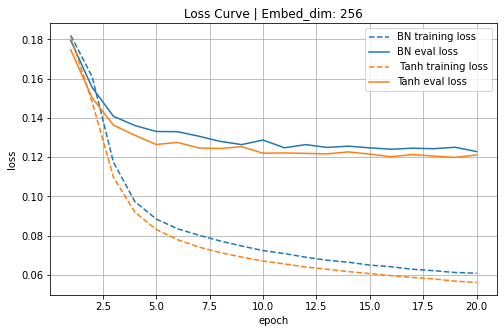

In [ ]:
print(f"Batch Norm Loss | total: {eval_loss[-1]:.4f}, positive: {pos_loss:.4f}, negative: {neg_loss:.4f}")
print(f"Tanh Loss | total: {eval_loss_base[-1]:.4f}, positive: {pos_loss_base:.4f}, negative: {neg_loss_base:.4f}")
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label="BN training loss", color=plt.cm.tab10(0), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="BN eval loss", color=plt.cm.tab10(0))
plt.plot(np.arange(1, epochs + 1), train_loss_base, label=" Tanh training loss", color=plt.cm.tab10(1), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), eval_loss_base, label="Tanh eval loss", color=plt.cm.tab10(1))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("batchnorm.png", bbox_inches="tight")
plt.show()

In [ ]:
# Normalize all vectors.
for i in range(len(bn_image_embeddings)):
    bn_image_embeddings[i] /= np.linalg.norm(bn_image_embeddings[i])
for i in range(len(tanh_image_embeddings)):
    tanh_image_embeddings[i] /= np.linalg.norm(tanh_image_embeddings[i])

In [ ]:
bn_image = bn_image_embeddings.flatten()
tanh_image = tanh_image_embeddings.flatten()

Maximum Absolute Value
   BatchNorm: 0.2405
   Tanh: 0.2113
Variance
   BatchNorm: 0.003906
   Tanh: 0.003905


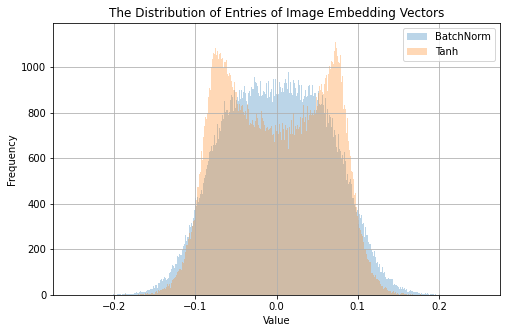

In [ ]:
print("Maximum Absolute Value")
print(f"   BatchNorm: {np.max(np.abs(bn_image)):.4f}")
print(f"   Tanh: {np.max(np.abs(tanh_image)):.4f}")
print("Variance")
print(f"   BatchNorm: {np.var(bn_image):.6f}")
print(f"   Tanh: {np.var(tanh_image):.6f}")
plt.figure(figsize=(8, 5))
plt.hist(bn_image, bins=1000, range=(-0.25,0.25), alpha=0.3, label="BatchNorm")
plt.hist(tanh_image, bins=1000, range=(-0.25,0.25), alpha=0.3, label="Tanh")
plt.title("The Distribution of Entries of Image Embedding Vectors")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid()
plt.legend()
plt.savefig("bn_tanh_dist.png", bbox_inches="tight")
plt.show()

## 3. Observation
From the experiment above, we saw that the BatchNorm produces a slightly better test loss.